In [1]:
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from segmentation_models import get_preprocessing

Segmentation Models: using `keras` framework.


In [2]:
# بارگذاری مدل آموزش‌دیده
model = load_model('C:/Users/Shahab/Downloads/Jupyter/Brain-Tumor/Model/tumor_segmentation_model2.h5', compile=False)

# تابع پیش‌پردازش
preprocess_input = get_preprocessing('resnet34')

# حجم سه بعدی

In [16]:
# مسیر فایل MRI سه‌بعدی (مثلاً .nii.gz)
nii_path = 'BraTS20_Training_055/BraTS20_Training_055_flair.nii'

In [17]:
# بارگذاری فایل
img_obj = nib.load(nii_path)
volume = img_obj.get_fdata()  # shape: (H, W, D)
volume

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [18]:
# خروجی نهایی ماسک سگمنت شده
segmented_volume = np.zeros(volume.shape)

In [19]:
for i in range(volume.shape[2]):  # برای هر اسلایس در عمق
    slice_ = volume[:, :, i]
    slice_resized = cv2.resize(slice_, (128, 128))
    slice_rgb = np.stack([slice_resized]*3, axis=-1)  # (128,128,3)
    slice_rgb = preprocess_input(slice_rgb)
    input_tensor = np.expand_dims(slice_rgb, axis=0)  # (1,128,128,3)

    # پیش‌بینی
    pred = model.predict(input_tensor)[0, :, :, 0]
    mask = (pred > 0.5).astype(np.uint8)
    mask_resized = cv2.resize(mask, (slice_.shape[1], slice_.shape[0]))  # بازگشت به اندازه اصلی

    segmented_volume[:, :, i] = mask_resized

1/1 [==============================] - 0s 56ms/step


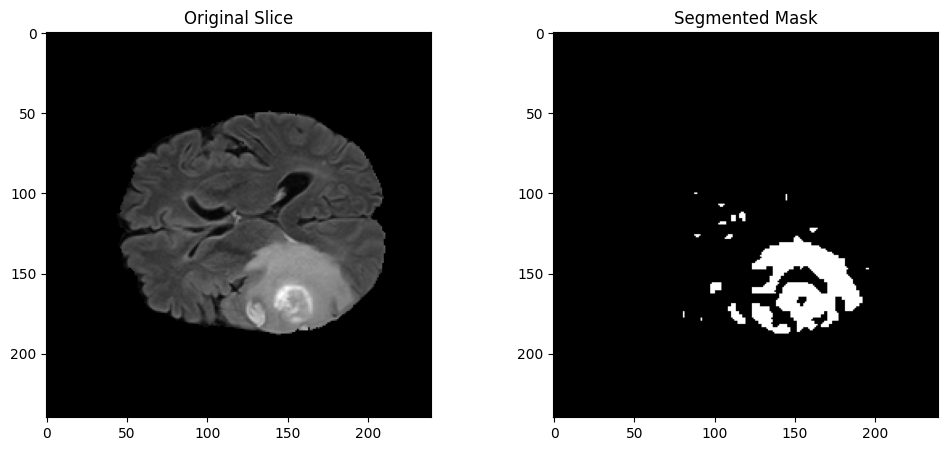

In [20]:
# نمایش یک اسلایس به دلخواه
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Original Slice')
plt.imshow(volume[:, :, volume.shape[2]//2], cmap='gray')

plt.subplot(1,2,2)
plt.title('Segmented Mask')
plt.imshow(segmented_volume[:, :, volume.shape[2]//2], cmap='gray')
plt.show()

# ارزیابی

In [28]:
import nibabel as nib
import numpy as np

# مسیر فایل سگمنت اصلی
seg_path = 'BraTS20_Training_055/BraTS20_Training_055_seg.nii'

# بارگذاری فایل
seg_img = nib.load(seg_path)
seg_data = seg_img.get_fdata()

In [45]:
tumor_mask = seg_data > 0 

In [46]:
num_voxels = np.sum(tumor_mask)

In [47]:
# گرفتن اندازه وکسل‌ها از affine
voxel_sizes = np.abs(seg_img.header.get_zooms())  # (x, y, z) اندازه هر وکسل برحسب mm
voxel_volume = voxel_sizes[0] * voxel_sizes[1] * voxel_sizes[2]  # mm³

In [48]:
tumor_volume_mm3 = num_voxels * voxel_volume
tumor_volume_cm3 = tumor_volume_mm3 / 1000  # به cm³

In [49]:
print(f"تعداد پیکسل‌های تومور: {num_voxels}")
print(f"حجم تومور: {tumor_volume_mm3:.2f} mm³")
print(f"حجم تومور: {tumor_volume_cm3:.2f} cm³")

تعداد پیکسل‌های تومور: 118394
حجم تومور: 118394.00 mm³
حجم تومور: 118.39 cm³


In [50]:
# -------------------------------------------------------------

In [51]:
tumor_mask_pred = segmented_volume > 0

In [52]:
num_voxels_pred = np.sum(tumor_mask_pred)

In [53]:
voxel_volume_pred = voxel_sizes[0] * voxel_sizes[1] * voxel_sizes[2]  # mm³

In [54]:
tumor_volume_mm3_pred = num_voxels_pred * voxel_volume_pred
tumor_volume_cm3_pred = tumor_volume_mm3_pred / 1000  # به cm³

In [55]:
print(f"تعداد پیکسل‌های تومور: {num_voxels}")
print(f"حجم تومور: {tumor_volume_mm3_pred:.2f} mm³")
print(f"حجم تومور: {tumor_volume_cm3_pred:.2f} cm³")

تعداد پیکسل‌های تومور: 118394
حجم تومور: 129848.00 mm³
حجم تومور: 129.85 cm³


# حجم دو بعدی

In [3]:
# ===== پارامترها =====
pixel_spacing_mm = 0.5  # مثلاً هر پیکسل برابر نیم میلی‌متر (0.5mm x 0.5mm)
slice_thickness_mm = 5   # ضخامت اسلایس، مثلا ۵ میلی‌متر

In [4]:
img_path = 'image_15.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (128, 128))
img_rgb = np.stack([img_resized]*3, axis=-1)  # (128,128,3)
img_rgb = preprocess_input(img_rgb)
input_tensor = np.expand_dims(img_rgb, axis=0)  # (1,128,128,3)

In [51]:
# ===== پیش‌بینی ماسک =====
slice_ = volume[:, :, volume.shape[2]//2 +20]
slice_resized = cv2.resize(slice_, (128, 128))
slice_rgb = np.stack([slice_resized]*3, axis=-1)  # (128,128,3)
slice_rgb = preprocess_input(slice_rgb)
input_tensor = np.expand_dims(slice_rgb, axis=0)  # (1,128,128,3)
# پیش‌بینی
pred = model.predict(input_tensor)[0, :, :, 0]

#pred = model.predict(input_tensor)[0, :, :, 0]

binary_mask = (pred > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 145ms/step


In [52]:
# ===== محاسبه تعداد پیکسل تومور =====
tumor_pixels = np.sum(binary_mask)

In [53]:
tumor_pixels

109

In [54]:
# ===== محاسبه مساحت (mm^2) =====
pixel_area = pixel_spacing_mm ** 2
tumor_area_mm2 = tumor_pixels * pixel_area

In [55]:
# ===== محاسبه حجم (mm^3) =====
tumor_volume_mm3 = tumor_area_mm2 * slice_thickness_mm

# ===== تبدیل به سانتی‌متر مکعب =====
tumor_volume_cm3 = tumor_volume_mm3 / 1000

print(f"🧠 حجم تقریبی تومور: {tumor_volume_cm3:.2f} cm³")

🧠 حجم تقریبی تومور: 0.14 cm³


# ارزیابی

In [56]:
#img_path = 'mask_15.png'
#img_mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

img_mask = seg_data[:, :, seg_data.shape[2]//2 +20]
img_resized_mask = cv2.resize(img_mask, (128, 128))

In [57]:
# ===== محاسبه تعداد پیکسل تومور =====
tumor_pixels_mask = np.sum(img_resized_mask != 0)

In [58]:
tumor_pixels_mask

104

In [59]:
# ===== محاسبه مساحت (mm^2) =====
pixel_area = pixel_spacing_mm ** 2
tumor_area_mm2_mask = tumor_pixels_mask * pixel_area

In [60]:
# ===== محاسبه حجم (mm^3) =====
tumor_volume_mm3_mask = tumor_area_mm2_mask * slice_thickness_mm

# ===== تبدیل به سانتی‌متر مکعب =====
tumor_volume_cm3_mask = tumor_volume_mm3_mask / 1000

print(f"🧠 حجم تقریبی تومور: {tumor_volume_cm3_mask:.2f} cm³")

🧠 حجم تقریبی تومور: 0.13 cm³


Text(0.5, 1.0, 'Predict : 0.14')

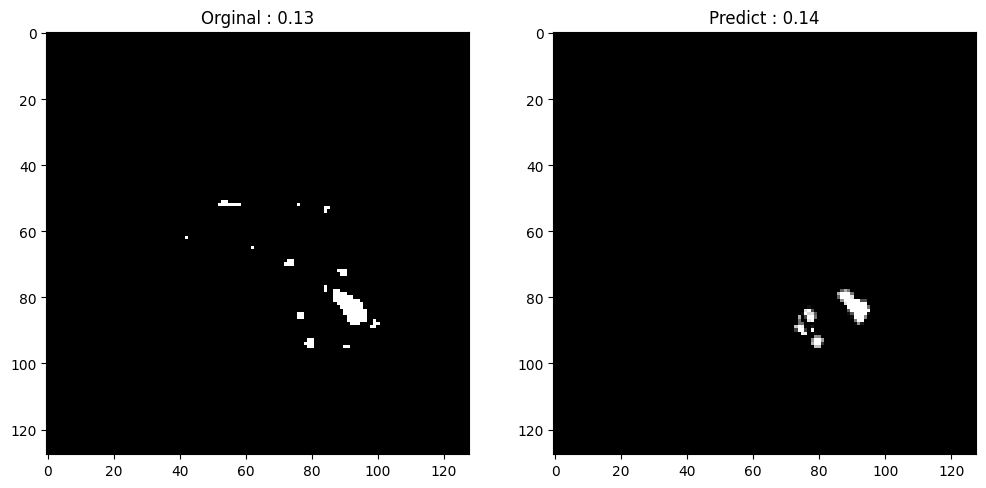

In [61]:
fig, ax = plt.subplots(1,2, figsize=(12,8))

ax[0].imshow(binary_mask, cmap='gray')
ax[0].set_title(f'Orginal : {tumor_volume_cm3_mask:.2f}')

ax[1].imshow(img_resized_mask, cmap='gray')
ax[1].set_title(f'Predict : {tumor_volume_cm3:.2f}')